Using ANN, CNN, LSTM combine with Keras Embedding Layer and GloVe word embedding to convert text to numeric form.

# Library

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense,LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D,Conv1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
%matplotlib notebook
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords

In [2]:
movie_reviews = pd.read_csv("E:/gitlab/machine-learning/NLP/dataset/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
print(movie_reviews.shape)
movie_reviews.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<IPython.core.display.Javascript object>


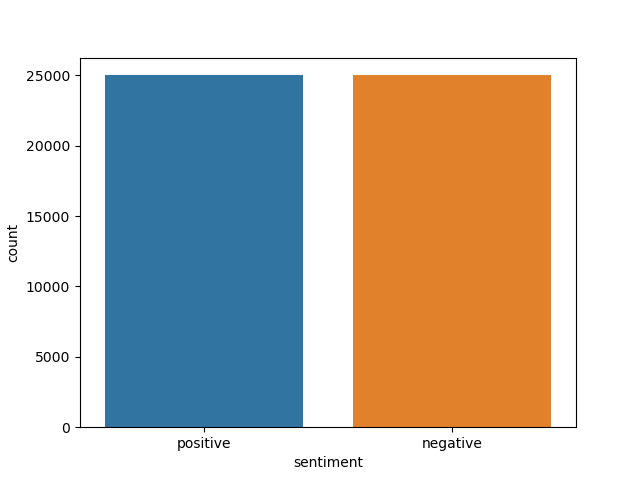

In [3]:
sns.countplot(x='sentiment', data=movie_reviews)
plt.show()

# Data Preprocessing

In [4]:
stemmer = WordNetLemmatizer()

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    #added
    #removes spaces from at the end 
    sentence = re.sub(r"\s+$", "", sentence)
    # Converting to Lowercase
    sentence = sentence.lower()
    # Lemmatization
    # reduce the word into dictionary root form
    sentence = sentence.split()
    sentence = [stemmer.lemmatize(word) for word in sentence]
    sentence = ' '.join(sentence)
    sentence = remove_stopwords(sentence)
    return sentence

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [5]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
X[3]

'basically family little boy jake think zombie closet parent fighting time movie slower soap opera suddenly jake decides rambo kill zombie ok going film decide thriller drama drama movie watchable parent divorcing arguing like real life jake closet totally ruin film expected boogeyman similar movie instead watched drama meaningless thriller spot playing parent descent dialog shot jake ignore'

In [6]:
X[3]

'basically family little boy jake think zombie closet parent fighting time movie slower soap opera suddenly jake decides rambo kill zombie ok going film decide thriller drama drama movie watchable parent divorcing arguing like real life jake closet totally ruin film expected boogeyman similar movie instead watched drama meaningless thriller spot playing parent descent dialog shot jake ignore'

# Labeling

In [8]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# split data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Preparing the Embedding Layer 

# Tokenizer

use the tokenizer class from the module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# padding

In [11]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add O at the end of the list until it reaches the max length. This process is called padding.

# use GloVe embeddings to create feature matrix.

load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values. 

In [12]:
embeddings_dictionary = dict()
glove_file = open('E:/gitlab/machine-learning/NLP/dataset/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

create an embedding matrix where each row number will correspond to
the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus. 

In [13]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

see that will contain as much rows as vocab_size (one for each word in the corpus)

In [14]:
X_train

array([[  18,   26,  190, ..., 3143,   86, 3340],
       [ 113,   41,  149, ..., 1400,   82,   19],
       [1055,   20,    9, ...,    0,    0,    0],
       ...,
       [ 559,  215,    1, ...,    0,    0,    0],
       [ 168,    2,  466, ...,    0,    0,    0],
       [ 345,    1,   29, ...,    0,    0,    0]])

In [15]:
y_train

array([0, 0, 1, ..., 0, 1, 1])

# Text Classification with Simple Neural Network 

In [13]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], 
                            input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          8327800   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 8,337,801
Trainable params: 10,001
Non-trainable params: 8,327,800
_________________________________________________________________
None


1. create a sequential() model. 
2. create our embedding layer. 

The embedding layer will have an input length of 100, the output vector dimension will also be 100. The vocabulary size will be 92547 words. Since we are not training our own embeddings and using the GloVe embedding, we set trainable to False weights and in the attribute we pass our own embedding matrix. 

since we are directly connecting our embedding layer to densely connected layer, we flatten the embedding layer. Finally, we add a dense layer with sigmoid activation function.

Since there are n words in our corpus and each word is represented as a 100 dimensional vector, the number of trainable parameter will be nx100 in the 
embedding layer. 

In the flattening layer, we simply multiply rows and column. 

Finally in the dense layer the number of parameters are 10000 (from the flattening layer) and 1 for the bias parameter, for a total of 10001.

In [14]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=6, 
                    verbose=1, 
                    validation_split=0.2) 
#The of 0.2 means that 20% of the training data is used to find the training accuracy 

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 2s 59us/sample - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/6
32000/32000 [==============================] - 1s 31us/sample - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/6
32000/32000 [==============================] - 1s 31us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/6
32000/32000 [==============================] - 1s 30us/sample - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/6
32000/32000 [==============================] - 1s 31us/sample - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/6
32000/32000 [==============================] - 1s 30us/sample - loss: 0.6932 - acc: 0.4983 - val_loss: 0.6932 - val_acc: 0.5000


## evaluate

In [15]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 1s 72us/sample - loss: 0.6932 - acc: 0.4961
Test Score: 0.6931804998397827
Test Accuracy: 0.4961


Overfitting occurs when your model performs better on the training set than the test set. Ideally, the performance difference between training and test sets should be minimum

<IPython.core.display.Javascript object>


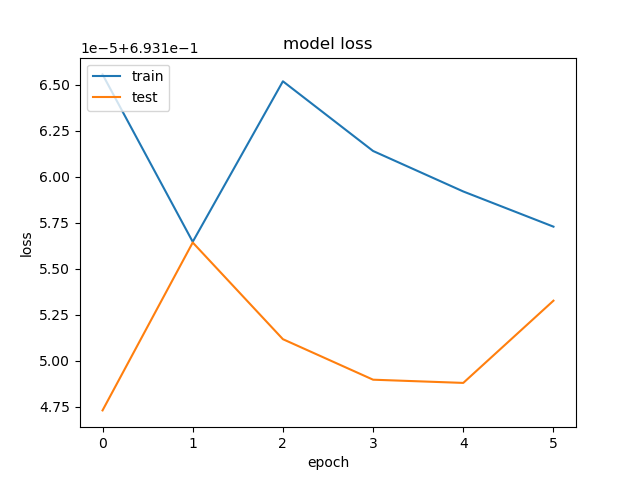

In [16]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Text Classification with Convolutional Neural Network

A convolutional network tries to find specific features in an image in the first layer. in the next layers, the initially detected features are joined together to form bigger features. the whole image is detected

In [20]:
model = Sequential()

#embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

# Convolution layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

# neural network layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          8327800   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 8,392,057
Trainable params: 64,257
Non-trainable params: 8,327,800
_________________________________________________________________
None


1. create a one-dimensional convolutional layer with 128 features, or kernels. The kernel size is 5 and the activation function used is sigmoid. 
2. add a global max pooling layer to reduce feature size. 
3. add a dense layer with sigmoid activation.

In [21]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=6, 
                    verbose=1, 
                    validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 9s 285us/sample - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/6
32000/32000 [==============================] - 2s 68us/sample - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/6
32000/32000 [==============================] - 2s 69us/sample - loss: 0.6932 - acc: 0.5007 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/6
32000/32000 [==============================] - 2s 67us/sample - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/6
32000/32000 [==============================] - 2s 70us/sample - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/6
10000/10000 [==============================] - 1s 119us/sample - loss: 0.6932 - acc: 0.4961


In [22]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6931523906707764
Test Accuracy: 0.4961


## plot result

In [32]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

<IPython.core.display.Javascript object>


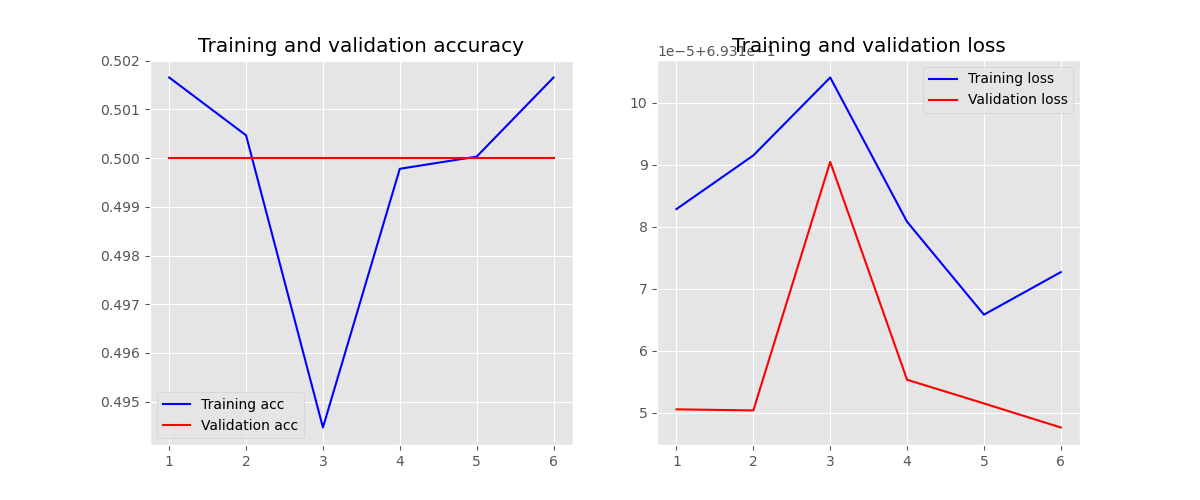

In [33]:
plt.style.use('ggplot')
plot_history(history)

# Text Classification with Recurrent Neural Network (LSTM)

RNN is a type of NN that is proven to work well with sequence data. since text is actually a sequence of word, a RNN is an automatic choice to solve text-related problems.

In [34]:
model = Sequential()

#embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], 
                            input_length=maxlen , trainable=False)
model.add(embedding_layer)

# RNN layer
model.add(LSTM(128))

#NN layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          8327800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 8,445,177
Trainable params: 117,377
Non-trainable params: 8,327,800
_________________________________________________________________
None


In [35]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=6, 
                    verbose=1, 
                    validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 6s 181us/sample - loss: 0.6932 - acc: 0.5047 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/6
32000/32000 [==============================] - 5s 146us/sample - loss: 0.6932 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/6
32000/32000 [==============================] - 5s 147us/sample - loss: 0.6932 - acc: 0.4968 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/6
32000/32000 [==============================] - 5s 146us/sample - loss: 0.6932 - acc: 0.4967 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/6
32000/32000 [==============================] - 5s 146us/sample - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/6
10000/10000 [==============================] - 2s 151us/sample - loss: 0.6931 - acc: 0.5039


In [36]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.693144194984436
Test Accuracy: 0.5039


## plot result

In [37]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

<IPython.core.display.Javascript object>


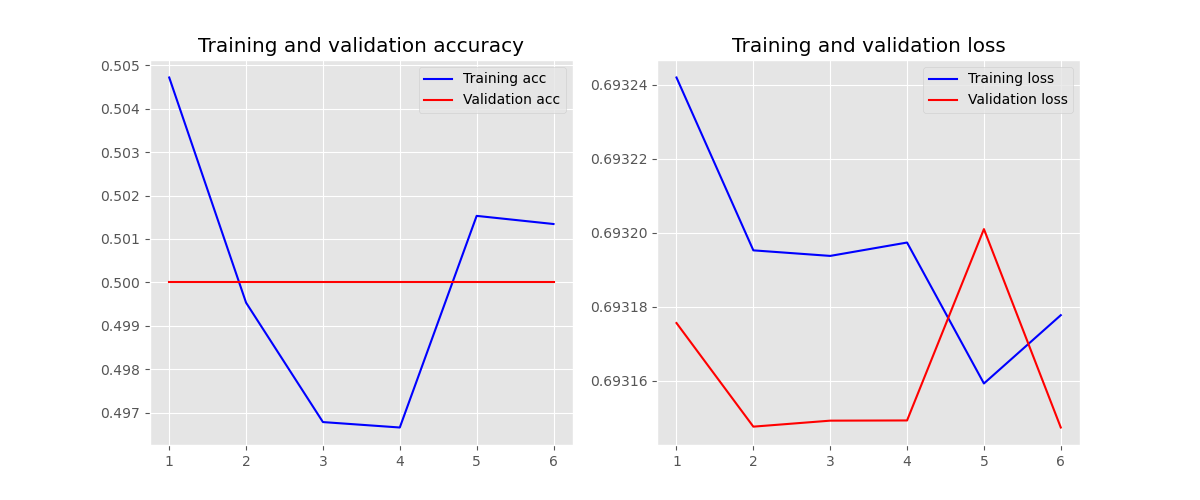

In [38]:
plt.style.use('ggplot')
plot_history(history)

The output shows that the difference between tha accuracy values for training and test sets is much smaller compared to the simple ANN and CNN. Similarly, the different between the loss values is also negligible, which shows that our model is not overfitting. 

# Making predictions on single Instance

In [28]:
instance = X[57]
print(instance)

laughed way rotten movie unbelievable woman leaf husband year marriage ha breakdown real estate office happens office manager come outside offer job hilarious thing know woman going yep lesbian ring true lifetime woman better movie clunky dialogue like want spend rest life feeling like chance happy help wealthy distant mother disapproves daughter new relationship sassy black maid unbelievable year film sassy black maid hattie mcdaniel turning grave woman ha husband freak want custody snotty teenage kid sheesh cliche left unturned


To predict the sentiment of this review, we have to convert this review into numeric form. We can do so using the tokenizer that we created in word embedding section. The method will convert the sentence into its numeric counter part.

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

Remember, we mapped the positive outputs to 1 and the negative outputs to 0.
However, the sigmoid function predicts floating value between O and 1. If the value is less than 0.5, the sentiment is considered negative where as if the value is greater than 0.5, the sentiment is considered as positive. The sentiment value for our single instance is 0.33 which means that our sentiment is predicted as negative, which actually is the case